In [53]:
!pip install koreanize-matplotlib
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import koreanize_matplotlib
import seaborn as sns

In [54]:
# countplot 함수 설정
def countplot(df, name):
    plt.figure(figsize=(8, 3))
    ax = sns.countplot(data=df, x=name, color='grey', alpha=0.5)

    # 전체 데이터 개수 계산
    total = len(df)

    # 각 막대 위에 개수와 비율 표시
    for p in ax.patches:
        count = int(p.get_height())  # 막대의 높이 (개수)
        percentage = 100 * count / total  # 비율 계산
        ax.annotate(f'{count}\n({percentage:.1f}%)',
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center',
                    fontsize=10, color='black',
                    xytext=(0, 8), textcoords='offset points', weight='bold', rotation = 45)
    plt.xticks(rotation=90)
    plt.title(name)
    return ax

In [55]:
def print_answer(sel, col):
    for row in range(len(sel)):
        text = sel[col].iloc[row]
        print(text)

In [56]:
def fillna_preprocessing(df):
    df.loc[df['인적사고'].isna()] = '없음'
    df.loc[df['물적사고'].isna()] = '없음'
    df.loc[df['사고객체'].isna()] = '기타 > 기타'
    df.loc[df['사고원인'].isna()] = '파악 불가'
    df.loc[df['작업프로세스'].isna()] = '기자제 운행 및 관리'
    return df

In [57]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# __1. Train Data 분석__

### __1.0 유효하지 않은 데이터 필터링__
* train 데이터에서 대부분의 재발방지대책 및 향후조치계획 행(정답 행) 탐색
* 정답 행 category화 수행
    * -> '수동적 대책'과 '능동적 대책'으로 분화

In [58]:
path = '/content/drive/MyDrive/# 협동 업무/한솔데코 데이콘/A3/DB/'
#path = '/DB/'
train = pd.read_csv(f'{path}train.csv', encoding='utf-8-sig')

In [59]:
train['공종(대분류)'] = train['공종'].str.split(' > ').str[0]
train['공종(중분류)'] = train['공종'].str.split(' > ').str[1]
train['사고객체(대분류)'] = train['사고객체'].str.split(' > ').str[0]
train['사고객체(중분류)'] = train['사고객체'].str.split(' > ').str[1]
train['장소(대분류)'] = train['장소'].str.split(' / ').str[0]
train['장소(중분류)'] = train['장소'].str.split(' / ').str[1]
train['부위(대분류)'] = train['부위'].str.split(' / ').str[0]
train['부위(중분류)'] = train['부위'].str.split(' / ').str[1]

In [63]:
filt_train = train[['공종', '사고객체', '공종(대분류)', '공종(중분류)', '사고객체(대분류)', '사고객체(중분류)',
                       '인적사고', '물적사고', '사고객체', '작업프로세스',
                       '장소(대분류)', '장소(중분류)', '부위(대분류)', '부위(중분류)', '사고원인', '재발방지대책 및 향후조치계획']]

#### __누락 데이터 탐색__

In [64]:
temp = train.isna().sum()
temp.loc[temp>0]

,0
인적사고,32
물적사고,1490
공종,11
사고객체,687
작업프로세스,63
사고원인,63
공종(대분류),11
공종(중분류),11
사고객체(대분류),687
사고객체(중분류),687


공종(대분류)
공종(중분류)
사고객체(대분류)
사고객체(중분류)
장소(대분류)
장소(중분류)
부위(대분류)
부위(중분류)
인적사고
물적사고


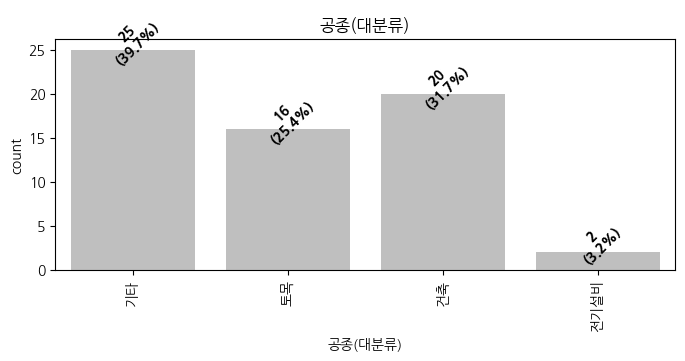

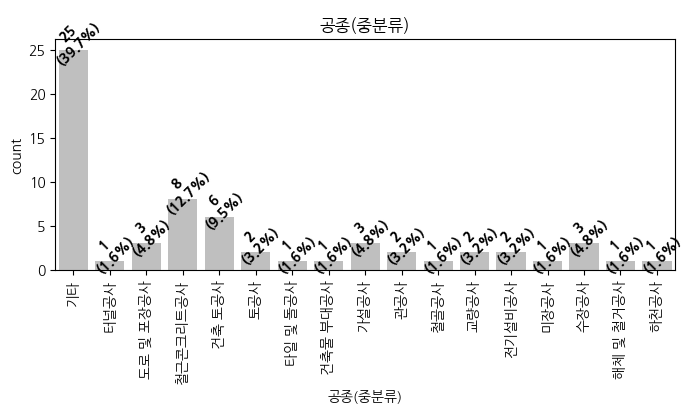

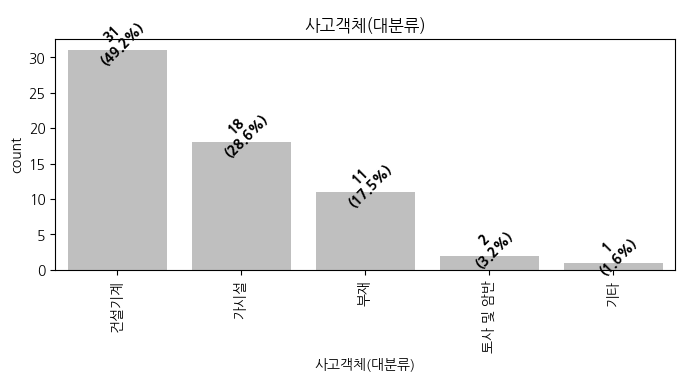

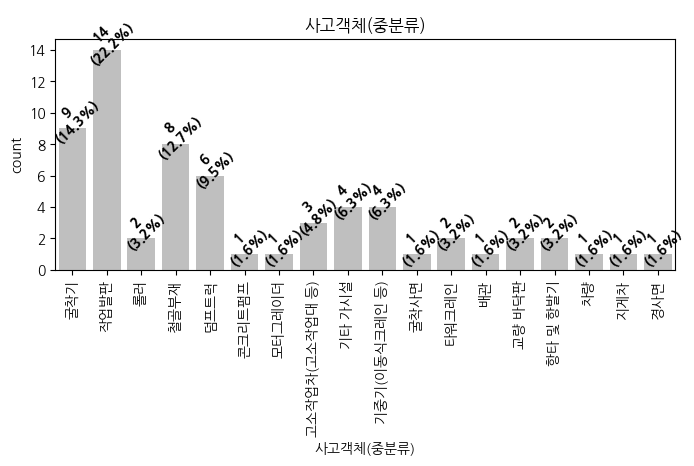

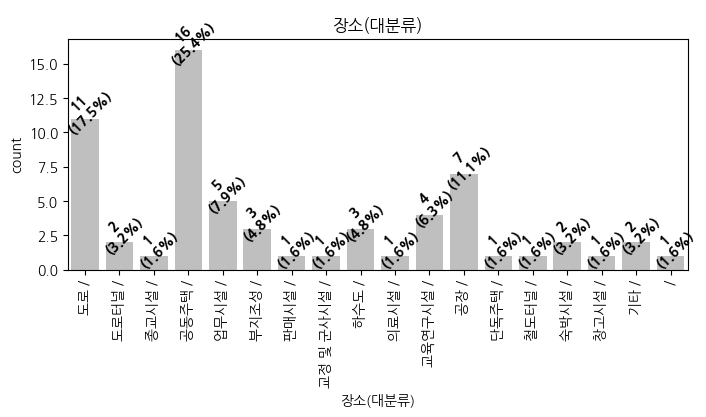

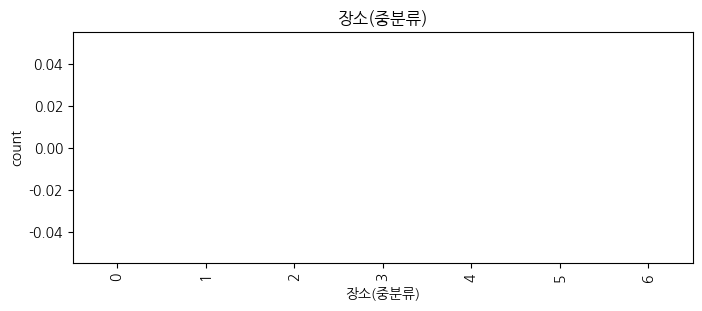

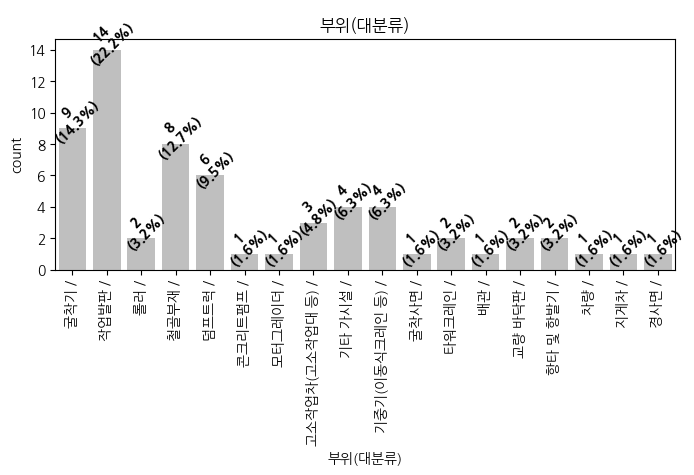

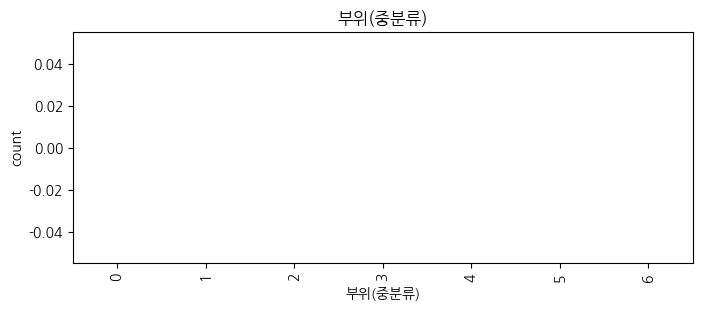

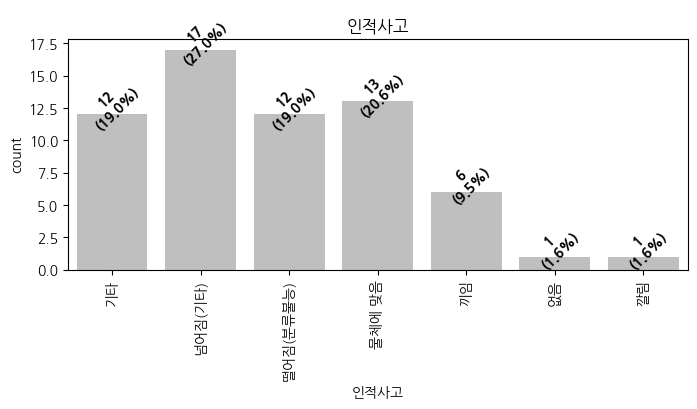

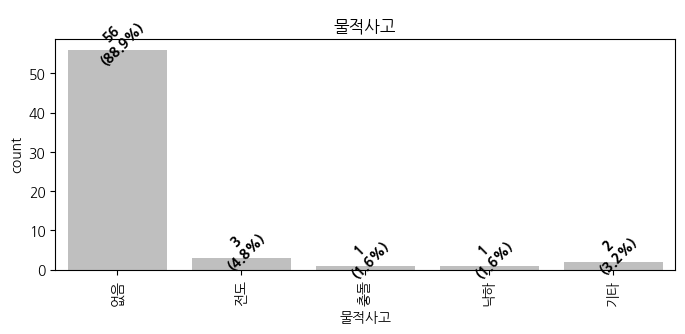

In [65]:
# 첫번째 확인 -> 작업프로세스가 누락인 경우 -> 기자제 운행 및 관리
columns = ['공종(대분류)', '공종(중분류)', '사고객체(대분류)', '사고객체(중분류)', '장소(대분류)', '장소(중분류)', '부위(대분류)', '부위(중분류)', '인적사고', '물적사고']#, '사고원인', '재발방지대책 및 향후조치계획']
sel = filt_train.loc[filt_train['작업프로세스'].isna()]
sel2 = sel[columns]
for col in columns:
    print(col)
    countplot(sel2, col)

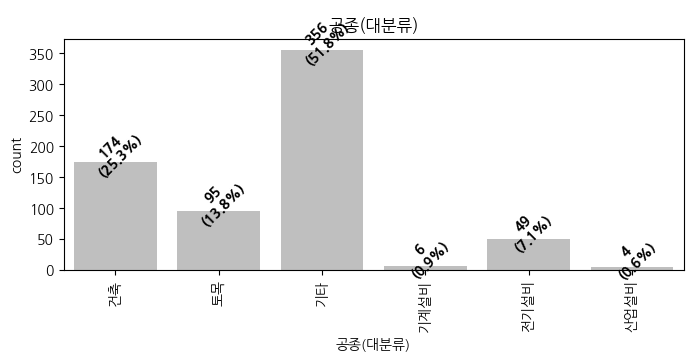

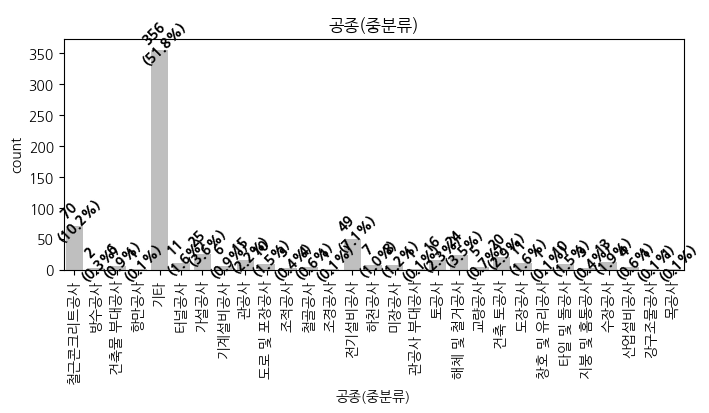

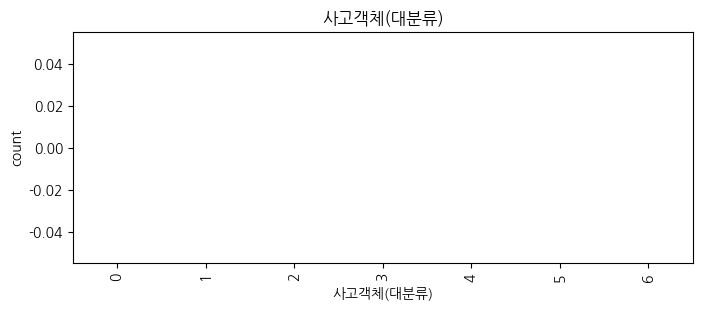

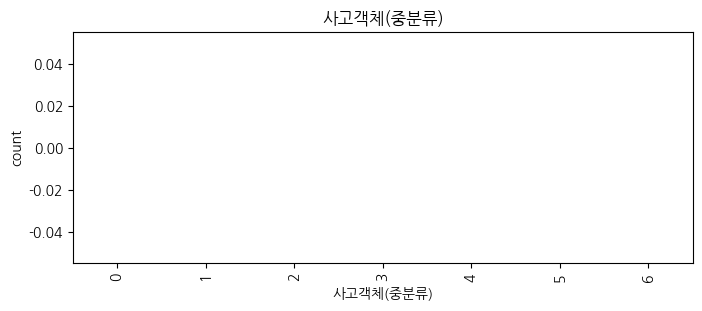

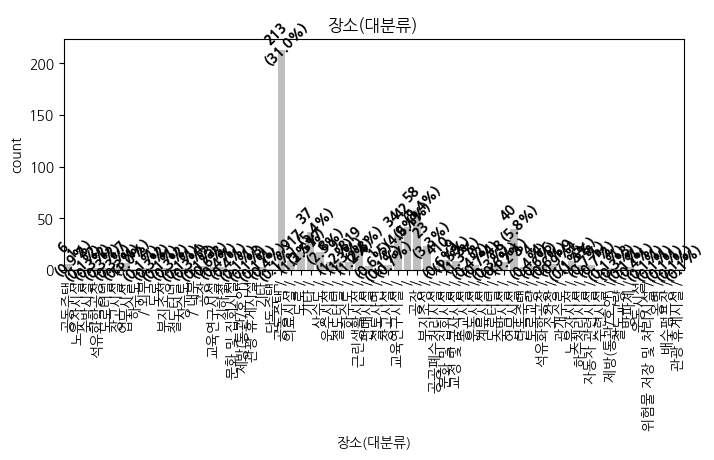

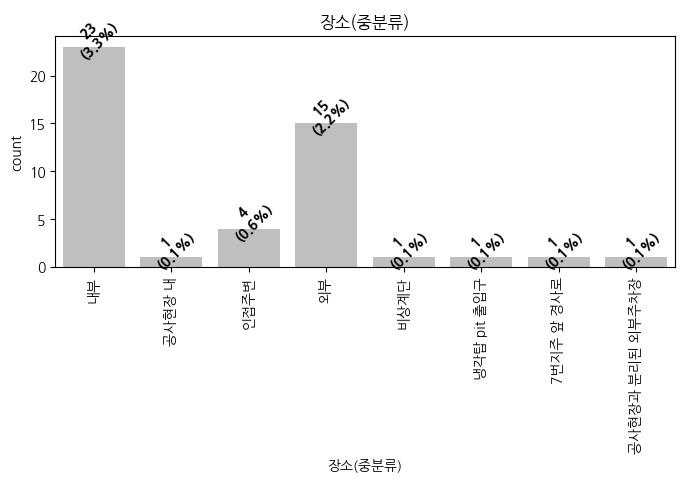

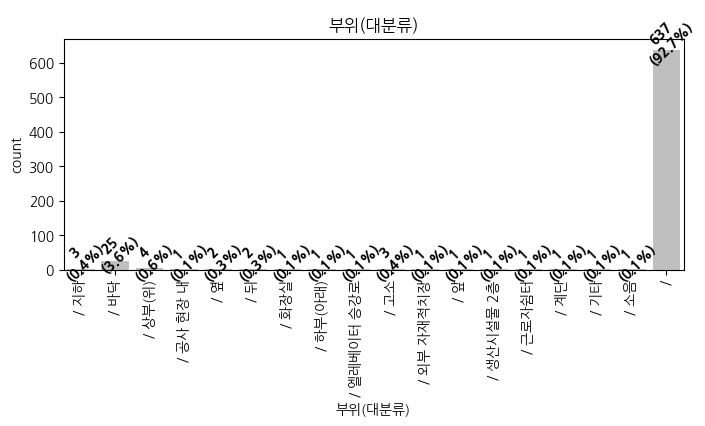

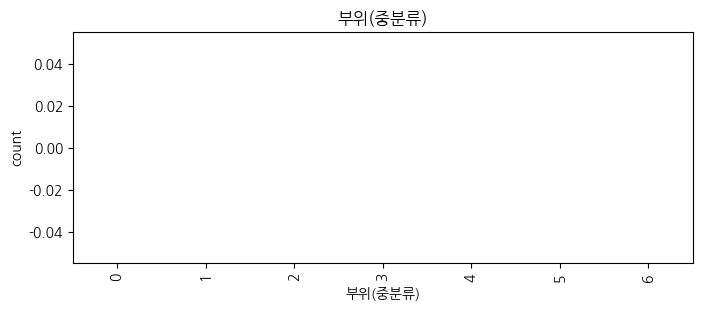

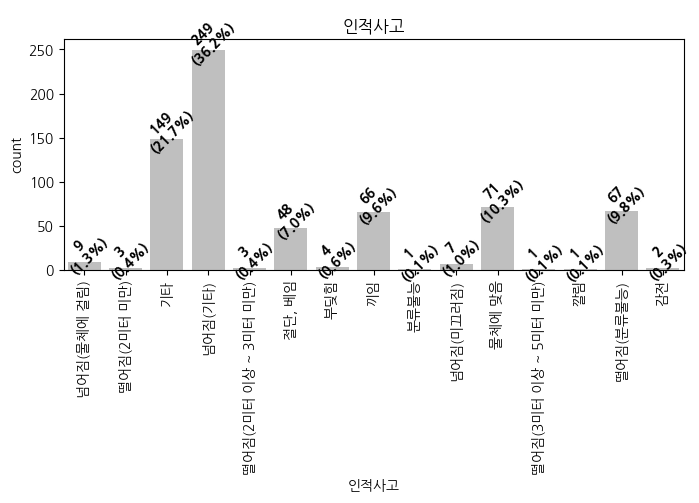

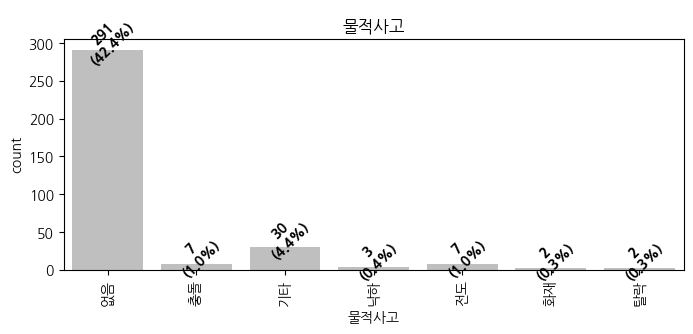

In [66]:
# 두 번째 확인 -> 사고객체가 na인 경우
sel = train.loc[train['사고객체'].isna()]
sel_ = train.loc[train['사고객체(대분류)'] == '건설자재']
sel__ = train.loc[train['사고객체(중분류)'] == '기타']
sel2 = sel[columns]
sel2_ = sel_[columns]
for col in columns:
    countplot(sel2, col)

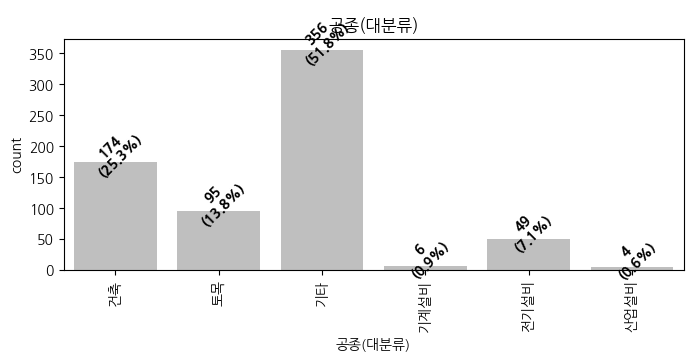

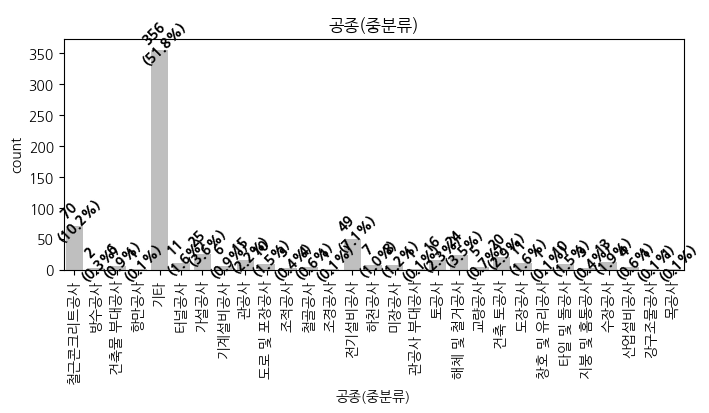

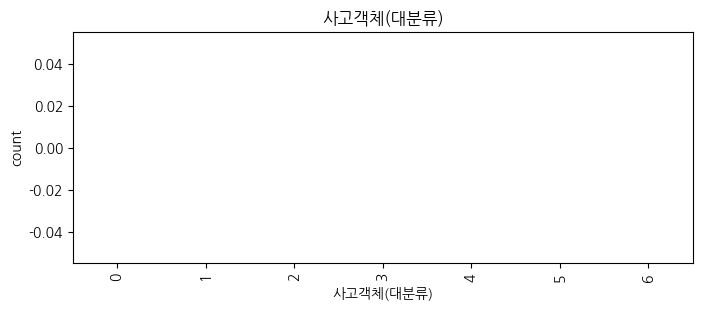

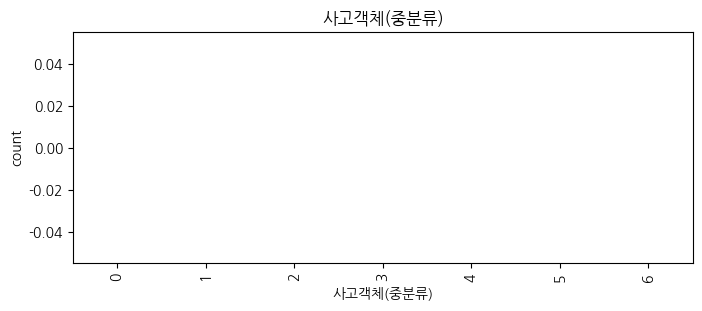

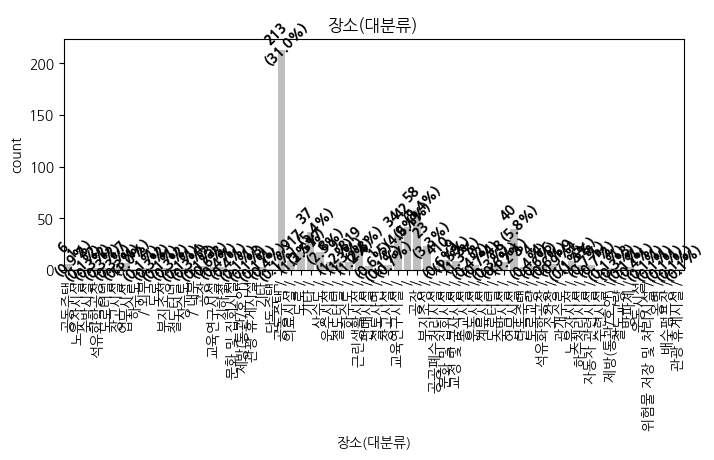

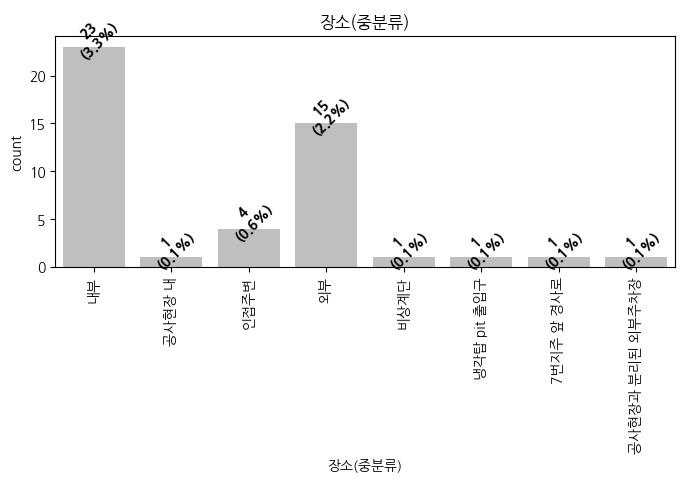

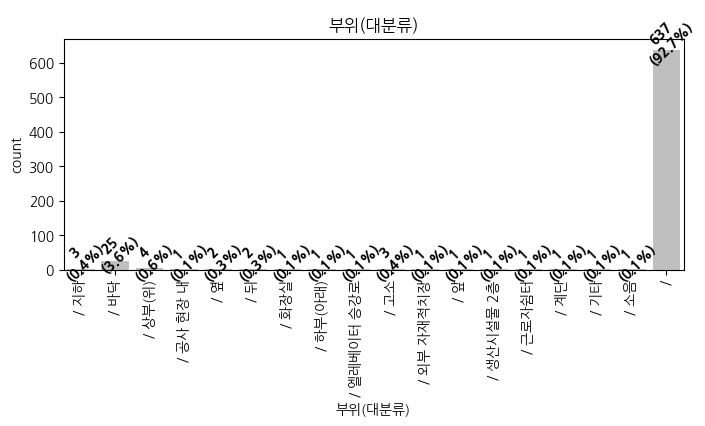

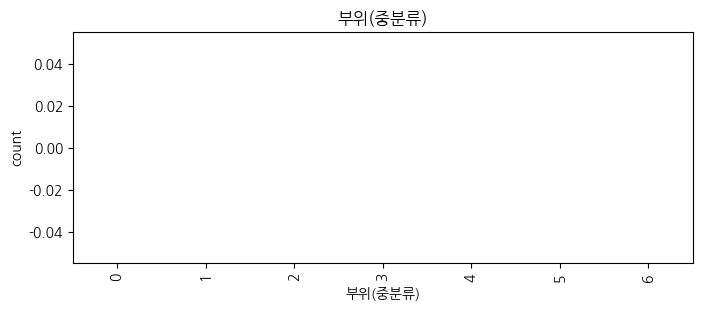

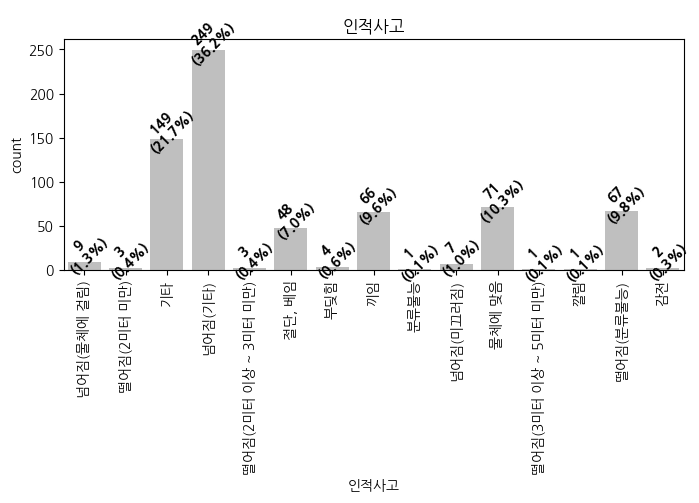

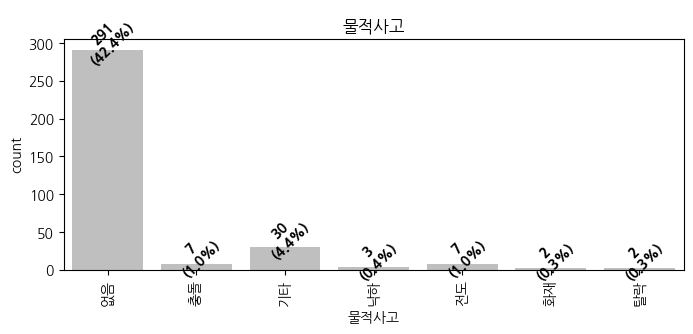

In [67]:
sel = train.loc[train['사고원인'].isna()]
columns = ['공종(대분류)', '공종(중분류)', '사고객체(대분류)', '사고객체(중분류)', '장소(대분류)', '장소(중분류)', '부위(대분류)', '부위(중분류)', '인적사고', '물적사고']
for col in columns:
    countplot(sel2, col)

#### __공종__

In [68]:
idx = train.loc[train['공종'].isna()].index

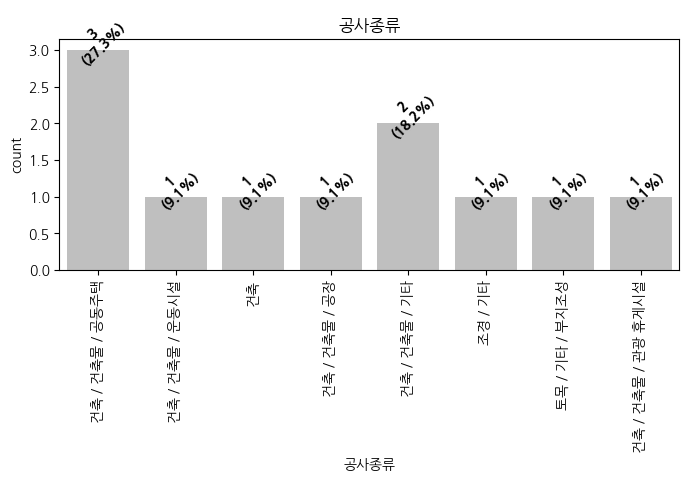

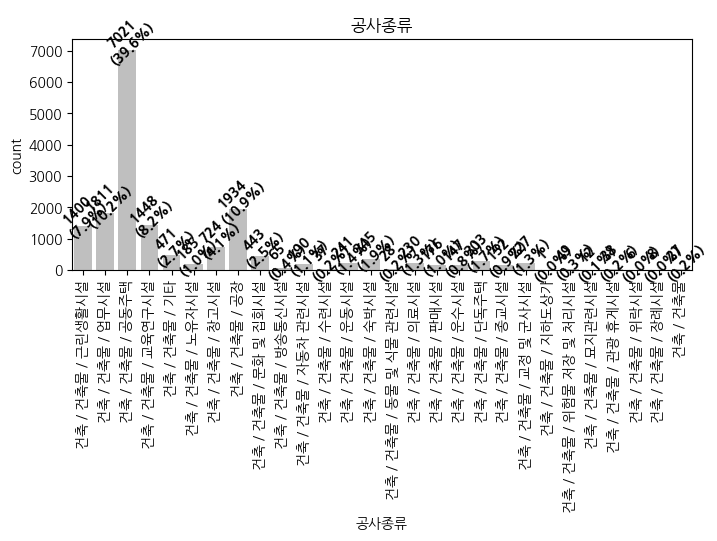

In [69]:
# 첫번째 확인 -> 공종이 누락인 경우 -> 기타와 큰 차이가 없음
columns = ['공사종류', '사고객체(대분류)', '사고객체(중분류)', '장소', '부위','인적사고', '물적사고', '작업프로세스']#, '사고원인', '재발방지대책 및 향후조치계획']
columns2 = ['공사종류']
sel = train.loc[train['공종'].isna()]
sel_ = train.loc[(train['공사종류'].str.contains('건축')) & (~train['공종'].isna())]
sel2 = sel[columns2]
sel2_ = sel_[columns2]
for col in columns2:
    countplot(sel2, col)
for col in columns2:
    countplot(sel2_, col)

In [70]:
for row in range(len(sel)):
    text1 = sel['공사종류'].iloc[row]
    text2 = sel['사고원인'].iloc[row]
    text3 = sel['사고객체'].iloc[row]
    text4 = sel['작업프로세스'].iloc[row]

In [71]:
cate = '건축 / 건축물 / 관광 휴게시설'
sel3 = sel.loc[sel['공사종류']==cate]
sel3_ = train.loc[train['공사종류']==cate]

In [72]:
for row in range(len(sel3_)):
    text1 = sel3_['공사종류'].iloc[row]
    text2 = sel3_['사고원인'].iloc[row]
    text3 = sel3_['사고객체'].iloc[row]
    text4 = sel3_['작업프로세스'].iloc[row]
    text5 = sel3_['공종'].iloc[row]
    if '이동' in str(text4):
        print(f'{row} \n 공사종류: {text1} \n 사고원인: {text2} \n 사고객체: {text3} \n 작업프로세스: {text4} \n 공종: {text5}')

19 
 공사종류: 건축 / 건축물 / 관광 휴게시설 
 사고원인: 퇴근길 경사로 내려오면서 작업자의 부주의 및  젖은 흙바닥 
 사고객체: nan 
 작업프로세스: 이동 
 공종: nan
22 
 공사종류: 건축 / 건축물 / 관광 휴게시설 
 사고원인: 모노레일 대차 롤러 고장 
 사고객체: 기타 > 작업대차 
 작업프로세스: 이동 
 공종: 토목 > 가설공사
23 
 공사종류: 건축 / 건축물 / 관광 휴게시설 
 사고원인: 전방주시 소홀 및 불안전한 행동 
 사고객체: 기타 > 기타 
 작업프로세스: 이동 
 공종: 토목 > 가설공사
25 
 공사종류: 건축 / 건축물 / 관광 휴게시설 
 사고원인: 전방주시의무 소흘하여 작업자가 이동 중 왼발목이 접질린 사고 
 사고객체: 기타 > 기타 
 작업프로세스: 이동 
 공종: 건축 > 철근콘크리트공사
27 
 공사종류: 건축 / 건축물 / 관광 휴게시설 
 사고원인: 작업자가 틀비계에서 작업 완료 후 인근 틀비계로 이동시 승강용 사다리를 이용하지 않고 안전난간을 넘어 이동하다 발생한 사고임(작업자의 불완전한 행동으로 인한 사고발생) 
 사고객체: 가시설 > 비계 
 작업프로세스: 이동 
 공종: 건축 > 철근콘크리트공사
32 
 공사종류: 건축 / 건축물 / 관광 휴게시설 
 사고원인: 현장내 이동중 바닥확인 미흡 
 사고객체: 건설자재 > 철근 
 작업프로세스: 이동 
 공종: 건축 > 금속공사


In [73]:
idx = [2856, 4706, 6235, 13429, 13708, 13866, 14143, 14715, 15805, 18108]
remove_idx = [9122]
nan = ['기타 > 기타', '건축 > 철근콘크리트공사', '기타 > 기타',
       '기타 > 기타', '기타 > 기타', '기타 > 기타',
       '건축 > 철근콘크리트공사', '기타 > 기타', '건축 > 철근콘크리트공사', '기타 > 기타']
print(len(idx), len(nan))

10 10


In [74]:
data = train[['사고원인', '재발방지대책 및 향후조치계획']]
data1 = train.loc[~train['재발방지대책 및 향후조치계획'].str.contains('재발방지대책 및 향후조치계획')]
data2 = data1.loc[~data1['재발방지대책 및 향후조치계획'].str.contains('재발 방지 대책')]
data3 = data2.loc[~data2['재발방지대책 및 향후조치계획'].str.contains('교육')]
data4 = data3.loc[~data3['재발방지대책 및 향후조치계획'].str.contains('계획')]

In [75]:
def fillna_gongjong(df, idx, nan, remove_idx):
    for i, j in enumerate(idx):
        df.loc[j, '공종'] = nan[i]
    df.drop(index=remove_idx, inplace=True)
    return df

In [76]:
def fillna_preprocessing(df):
    df.loc[df['인적사고'].isna()] = '없음'
    df.loc[df['물적사고'].isna()] = '없음'
    df.loc[df['사고객체'].isna()] = '기타 > 기타'
    df.loc[df['사고원인'].isna()] = '파악 불가'
    df.loc[df['작업프로세스'].isna()] = '기자제 운행 및 관리'
    return df

In [77]:
train = pd.read_csv(f'{path}train.csv', encoding='utf-8-sig')
test = pd.read_csv(f'{path}test.csv', encoding = 'utf-8-sig')

train = fillna_preprocessing(train)
train = fillna_gongjong(train, idx, nan, remove_idx)
test = fillna_preprocessing(test)

train.to_csv(f'{path}train_preprocessing.csv', index=0, encoding='utf-8-sig')
test.to_csv(f'{path}test_preprocessing.csv', index=0, encoding = 'utf-8-sig')